In [1]:
import pandas as pd
df=pd.read_csv('data/df_top15.csv')

In [2]:
# 원핫 인코딩 적용
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder( sparse_output=False)
encoded_countries = encoder.fit_transform(df[['국적지역']])

encoded_df = pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out(['국적지역']))

# 기존 데이터프레임과 병합
df_encoded = pd.concat([df[['년', '월', '입국자수']], encoded_df], axis=1)

In [3]:
df_encoded

,년,월,입국자수,국적지역_대만,국적지역_러시아,국적지역_말레이시아,국적지역_미국,국적지역_베트남,국적지역_싱가포르,국적지역_영국,국적지역_오스트레일리아,국적지역_인도네시아,국적지역_일본,국적지역_중국,국적지역_캐나다,국적지역_태국,국적지역_필리핀,국적지역_홍콩
0,2018,1,78321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,2,90673,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,3,96811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,4,107719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,5,91102,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2024,8,61592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
713,2024,9,39815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
714,2024,10,52005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
715,2024,11,46366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['입국자수'])
y = df_encoded['입국자수']

In [5]:
#트레이닝, 테스트 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [6]:
from xgboost import XGBRegressor

# XGBoost 회귀 모델 학습
xgb_model = XGBRegressor(n_estimators=80, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [7]:
# 예측 수행
y_pred_xgb = xgb_model.predict(X_test)


In [8]:
#성능평가
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_xgb)


0.9804311394691467

In [9]:
# 2025년, 2026년 데이터를 생성하여 예측
future_years = [2025, 2026]
future_months = list(range(1, 13))  # 1월~12월

# 기존 데이터에서 국적 리스트 추출
countries = encoder.get_feature_names_out(['국적지역'])

# 예측을 위한 데이터 생성
future_data = []
for year in future_years:
    for month in future_months:
        for country in countries:
            # 국가별 원핫 인코딩 값 생성
            country_encoding = [1 if c == country else 0 for c in countries]
            future_data.append([year, month] + country_encoding)

# 데이터프레임 변환
future_df = pd.DataFrame(future_data, columns=['년', '월'] + list(countries))

# XGBoost 모델을 사용하여 미래 입국자 수 예측
future_predictions_xgb = xgb_model.predict(future_df)

# 결과 데이터프레임 생성
future_df['예측 입국자수'] = future_predictions_xgb

In [10]:
future_df

,년,월,국적지역_대만,국적지역_러시아,국적지역_말레이시아,국적지역_미국,국적지역_베트남,국적지역_싱가포르,국적지역_영국,국적지역_오스트레일리아,국적지역_인도네시아,국적지역_일본,국적지역_중국,국적지역_캐나다,국적지역_태국,국적지역_필리핀,국적지역_홍콩,예측 입국자수
0,2025,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105431.843750
1,2025,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18958.263672
2,2025,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,23736.001953
3,2025,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,69946.796875
4,2025,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,32414.441406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2026,12,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,311202.531250
356,2026,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,24938.886719
357,2026,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,34567.656250
358,2026,12,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40550.683594


In [11]:
#각 국적지역-국적 컬럼을 원래처럼 변환
future_df['국적지역'] = future_df[countries].idxmax(axis=1)

# 년, 월, 국적지역, 예측 입국자수 컬럼만 선택
future_df = future_df[['년', '월', '국적지역', '예측 입국자수']]
#국적지역_을 제거
future_df['국적지역'] = future_df['국적지역'].str.replace('국적지역_', '')
#국적지역별로 정렬
future_df = future_df.sort_values(by=['국적지역', '년', '월'])
#예측입국자수 정수로 변환
future_df['예측 입국자수'] = future_df['예측 입국자수'].astype(int).reset_index(drop=True)

future_df

/var/folders/wz/cf10k4857715p70flsxw2g9m0000gn/T/ipykernel_34476/1316843842.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['국적지역'] = future_df['국적지역'].str.replace('국적지역_', '')


,년,월,국적지역,예측 입국자수
0,2025,1,대만,105431
15,2025,2,대만,114388
30,2025,3,대만,23529
45,2025,4,대만,25596
60,2025,5,대만,23736
...,...,...,...,...
299,2026,8,홍콩,34567
314,2026,9,홍콩,38933
329,2026,10,홍콩,37780
344,2026,11,홍콩,44795


In [12]:
future_df[future_df['국적지역']=='미국']

,년,월,국적지역,예측 입국자수
3,2025,1,미국,114388
18,2025,2,미국,126297
33,2025,3,미국,25596
48,2025,4,미국,23736
63,2025,5,미국,30796
78,2025,6,미국,117059
93,2025,7,미국,121361
108,2025,8,미국,32414
123,2025,9,미국,30796
138,2025,10,미국,28307


In [13]:
df[df['국적지역']=='미국']

,년,월,국적지역,입국자수,날짜
144,2018,1,미국,68071,2018-01-01
145,2018,2,미국,76797,2018-02-01
146,2018,3,미국,87866,2018-03-01
147,2018,4,미국,100670,2018-04-01
148,2018,5,미국,92902,2018-05-01
149,2018,6,미국,102403,2018-06-01
150,2018,7,미국,98111,2018-07-01
151,2018,8,미국,84466,2018-08-01
152,2018,9,미국,85895,2018-09-01
153,2018,10,미국,108108,2018-10-01


In [15]:
#한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스에서 한글 폰트 사용

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

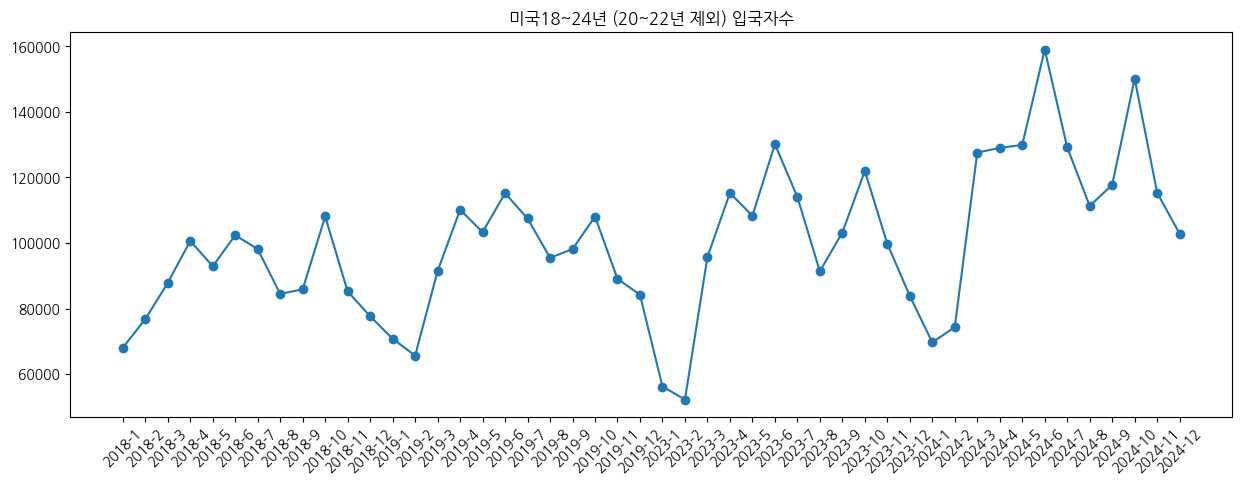

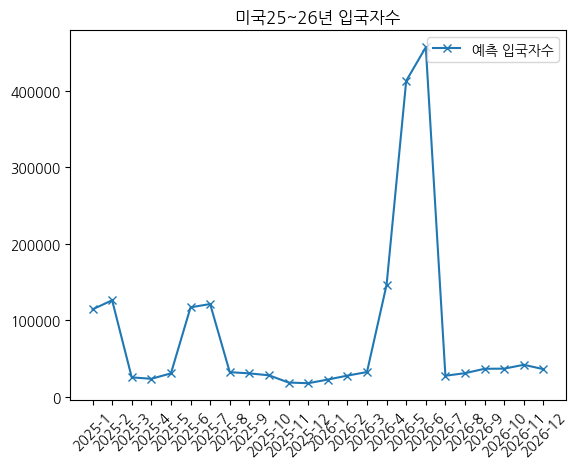

In [17]:
#과거, 미래 입국자를 그래프로 확인

import matplotlib.pyplot as plt

select_country = '미국'
#선택한 나라 데이터만 추출
select_df = df[df['국적지역']==select_country]

#입국자수 그래프
plt.figure(figsize=(15, 5))
plt.title(select_country + '18~24년 (20~22년 제외) 입국자수')
plt.plot(select_df['년'].astype(str) + '-' + select_df['월'].astype(str), select_df['입국자수'], marker='o', label='실제 입국자수')
plt.xticks(rotation=45)
plt.show()
#선택한 나라 예측입국자수 그래프
plt.title(select_country + '25~26년 입국자수')
plt.plot(future_df[future_df['국적지역']==select_country]['년'].astype(str) + '-' + future_df[future_df['국적지역']==select_country]['월'].astype(str), future_df[future_df['국적지역']==select_country]['예측 입국자수'], marker='x', label='예측 입국자수')

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# 점수는 높았으나 예측인원이 기존 입국데이터와 비교했을때 예측인원이 너무 낮음

In [1]:
# 월 데이터를 계절성 반영되도록 수정 sin, cos 값으로 변환

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('data/df_top15.csv')

In [4]:
# 월 데이터를 계절성 반영되도록 수정


import numpy as np


df['월_sin'] = np.sin(2 * np.pi * df['월'] / 12)
df['월_cos'] = np.cos(2 * np.pi * df['월'] / 12)

In [5]:
df

,년,월,국적지역,입국자수,날짜,월_sin,월_cos
0,2018,1,대만,78321,2018-01-01,5.000000e-01,8.660254e-01
1,2018,2,대만,90673,2018-02-01,8.660254e-01,5.000000e-01
2,2018,3,대만,96811,2018-03-01,1.000000e+00,6.123234e-17
3,2018,4,대만,107719,2018-04-01,8.660254e-01,-5.000000e-01
4,2018,5,대만,91102,2018-05-01,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...
712,2024,8,홍콩,61592,2024-08-01,-8.660254e-01,-5.000000e-01
713,2024,9,홍콩,39815,2024-09-01,-1.000000e+00,-1.836970e-16
714,2024,10,홍콩,52005,2024-10-01,-8.660254e-01,5.000000e-01
715,2024,11,홍콩,46366,2024-11-01,-5.000000e-01,8.660254e-01


In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_countries = encoder.fit_transform(df[['국적지역']])
encoded_df = pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out(['국적지역']))
df_encoded = pd.concat([df[['년', '월_sin', '월_cos', '입국자수']], encoded_df], axis=1)


In [7]:
df_encoded

,년,월_sin,월_cos,입국자수,국적지역_대만,국적지역_러시아,국적지역_말레이시아,국적지역_미국,국적지역_베트남,국적지역_싱가포르,국적지역_영국,국적지역_오스트레일리아,국적지역_인도네시아,국적지역_일본,국적지역_중국,국적지역_캐나다,국적지역_태국,국적지역_필리핀,국적지역_홍콩
0,2018,5.000000e-01,8.660254e-01,78321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,8.660254e-01,5.000000e-01,90673,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,1.000000e+00,6.123234e-17,96811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,8.660254e-01,-5.000000e-01,107719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,5.000000e-01,-8.660254e-01,91102,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2024,-8.660254e-01,-5.000000e-01,61592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
713,2024,-1.000000e+00,-1.836970e-16,39815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
714,2024,-8.660254e-01,5.000000e-01,52005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
715,2024,-5.000000e-01,8.660254e-01,46366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['입국자수'])
y = df_encoded['입국자수']

In [9]:
X

,년,월_sin,월_cos,국적지역_대만,국적지역_러시아,국적지역_말레이시아,국적지역_미국,국적지역_베트남,국적지역_싱가포르,국적지역_영국,국적지역_오스트레일리아,국적지역_인도네시아,국적지역_일본,국적지역_중국,국적지역_캐나다,국적지역_태국,국적지역_필리핀,국적지역_홍콩
0,2018,5.000000e-01,8.660254e-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,8.660254e-01,5.000000e-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018,1.000000e+00,6.123234e-17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,8.660254e-01,-5.000000e-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018,5.000000e-01,-8.660254e-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2024,-8.660254e-01,-5.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
713,2024,-1.000000e+00,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
714,2024,-8.660254e-01,5.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
715,2024,-5.000000e-01,8.660254e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
y

0       78321
1       90673
2       96811
3      107719
4       91102
        ...  
712     61592
713     39815
714     52005
715     46366
716     58347
Name: 입국자수, Length: 717, dtype: int64

In [11]:
#트레이닝, 테스트 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [12]:
from xgboost import XGBRegressor

# XGBoost 회귀 모델 학습
xgb_model1 = XGBRegressor(
    n_estimators=100, learning_rate=0.05, max_depth=8,reg_lambda=0.5, random_state=42)
xgb_model1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
# 예측 수행
y_pred_xgb1 = xgb_model1.predict(X_test)
#성능평가
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_xgb1)

0.9871369004249573

In [14]:
# 2025년, 2026년 데이터를 생성하여 예측
future_years = [2025, 2026]
future_months = list(range(1, 13))  # 1월~12월

# 기존 데이터에서 국적 리스트 추출
countries = encoder.get_feature_names_out(['국적지역'])

# 예측을 위한 데이터 생성
future_data = []
for year in future_years:
    for month in future_months:
        for country in countries:
            # 국가별 원핫 인코딩 값 생성
            country_encoding = [1 if c == country else 0 for c in countries]
            future_data.append([year, month] + country_encoding)

# 데이터프레임 변환
future_df = pd.DataFrame(future_data, columns=['년', '월'] + list(countries))

# 월을 사인/코사인 값으로 변환 (훈련 데이터와 동일한 변환 방식 적용)
future_df['월_sin'] = np.sin(2 * np.pi * future_df['월'] / 12)
future_df['월_cos'] = np.cos(2 * np.pi * future_df['월'] / 12)

# '월' 컬럼 삭제 (훈련 데이터에 없었으므로 제거)
future_df = future_df.drop(columns=['월'])

# 훈련 데이터와 동일한 컬럼 순서 유지
future_df = future_df[X_train.columns]

# XGBoost 모델을 사용하여 미래 입국자 수 예측
future_predictions_xgb1 = xgb_model1.predict(future_df)

# 예측값을 반올림하여 정수 변환
future_df['예측 입국자수'] = np.round(future_predictions_xgb1).astype(int)

# 각 국적지역-국적 컬럼을 원래처럼 변환
future_df['국적지역'] = future_df[countries].idxmax(axis=1)

# 년, 월, 국적지역, 예측 입국자수 컬럼만 선택
future_df = future_df[['년', '월_sin', '월_cos', '국적지역', '예측 입국자수']]


In [15]:
future_df

,년,월_sin,월_cos,국적지역,예측 입국자수
0,2025,5.000000e-01,0.866025,국적지역_대만,115778
1,2025,5.000000e-01,0.866025,국적지역_러시아,15280
2,2025,5.000000e-01,0.866025,국적지역_말레이시아,26068
3,2025,5.000000e-01,0.866025,국적지역_미국,69581
4,2025,5.000000e-01,0.866025,국적지역_베트남,30823
...,...,...,...,...,...
355,2026,-2.449294e-16,1.000000,국적지역_중국,315197
356,2026,-2.449294e-16,1.000000,국적지역_캐나다,20587
357,2026,-2.449294e-16,1.000000,국적지역_태국,36321
358,2026,-2.449294e-16,1.000000,국적지역_필리핀,44596


In [16]:
# 월_sin, 월_cos를 원래 월 값으로 변환
future_df['월'] = np.round(
    (np.arctan2(future_df['월_sin'], future_df['월_cos']) / (2 * np.pi) * 12) + 1
).astype(int)

# 음수 값이 나오지 않도록 보정 (1~12 범위로 변환)
future_df['월'] = future_df['월'] % 12
future_df['월'] = future_df['월'].replace(0, 12)  # 0이 나오면 12로 변경

# 변환 후 필요 없는 월_sin, 월_cos 삭제
future_df = future_df.drop(columns=['월_sin', '월_cos'])



In [17]:
#국적지역 컬럼 밸류들에 국적지역_ 삭제
future_df['국적지역'] = future_df['국적지역'].str.replace('국적지역_', '')

In [18]:
#컬럼순서 변경
future_df = future_df[['년', '월', '국적지역', '예측 입국자수']]

In [19]:
future_df

,년,월,국적지역,예측 입국자수
0,2025,2,대만,115778
1,2025,2,러시아,15280
2,2025,2,말레이시아,26068
3,2025,2,미국,69581
4,2025,2,베트남,30823
...,...,...,...,...
355,2026,1,중국,315197
356,2026,1,캐나다,20587
357,2026,1,태국,36321
358,2026,1,필리핀,44596


In [20]:
future_df['월'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1])

In [21]:
# 국적지역 > 년 > 월 순서로 정렬
future_df = future_df.sort_values(by=['국적지역', '년', '월']).reset_index(drop=True)


In [22]:
df['국적지역'].unique()

array(['대만', '러시아', '말레이시아', '미국', '베트남', '싱가포르', '영국', '오스트레일리아',
       '인도네시아', '일본', '중국', '캐나다', '태국', '필리핀', '홍콩'], dtype=object)

In [23]:
future_df[future_df['국적지역']=='오스트레일리아']

,년,월,국적지역,예측 입국자수
168,2025,1,오스트레일리아,25498
169,2025,2,오스트레일리아,18079
170,2025,3,오스트레일리아,16926
171,2025,4,오스트레일리아,22393
172,2025,5,오스트레일리아,21215
173,2025,6,오스트레일리아,20579
174,2025,7,오스트레일리아,20270
175,2025,8,오스트레일리아,18449
176,2025,9,오스트레일리아,17978
177,2025,10,오스트레일리아,22595


In [24]:
df[df['국적지역']=='오스트레일리아']

,년,월,국적지역,입국자수,날짜,월_sin,월_cos
336,2018,1,오스트레일리아,11815,2018-01-01,5.000000e-01,8.660254e-01
337,2018,2,오스트레일리아,8860,2018-02-01,8.660254e-01,5.000000e-01
338,2018,3,오스트레일리아,10790,2018-03-01,1.000000e+00,6.123234e-17
339,2018,4,오스트레일리아,15608,2018-04-01,8.660254e-01,-5.000000e-01
340,2018,5,오스트레일리아,12550,2018-05-01,5.000000e-01,-8.660254e-01
341,2018,6,오스트레일리아,11942,2018-06-01,1.224647e-16,-1.000000e+00
342,2018,7,오스트레일리아,11602,2018-07-01,-5.000000e-01,-8.660254e-01
343,2018,8,오스트레일리아,11697,2018-08-01,-8.660254e-01,-5.000000e-01
344,2018,9,오스트레일리아,15405,2018-09-01,-1.000000e+00,-1.836970e-16
345,2018,10,오스트레일리아,15019,2018-10-01,-8.660254e-01,5.000000e-01


In [25]:
#한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스에서 한글 폰트 사용

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [26]:
df['국적지역'].unique()

array(['대만', '러시아', '말레이시아', '미국', '베트남', '싱가포르', '영국', '오스트레일리아',
       '인도네시아', '일본', '중국', '캐나다', '태국', '필리핀', '홍콩'], dtype=object)

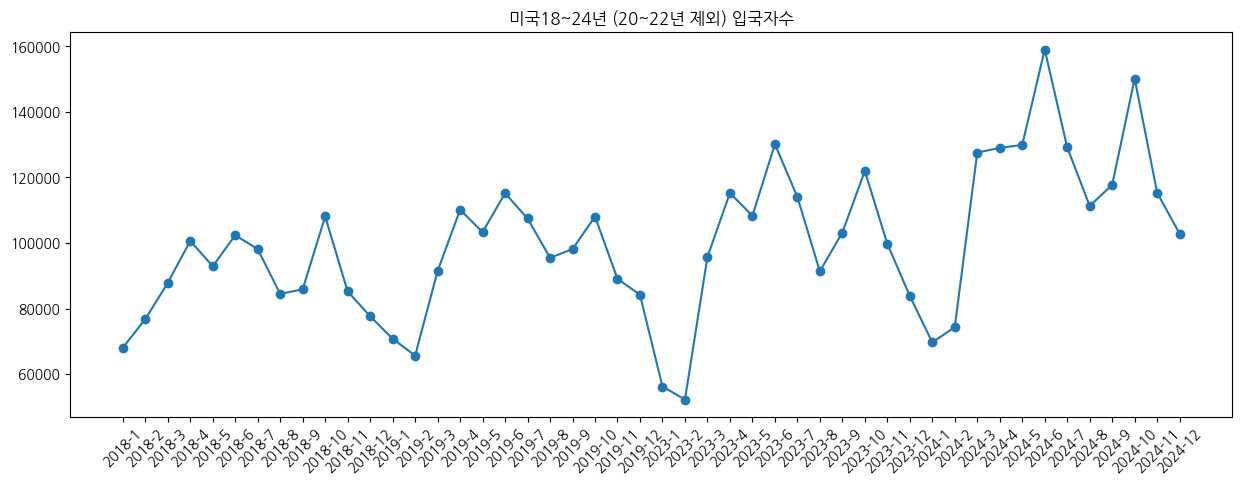

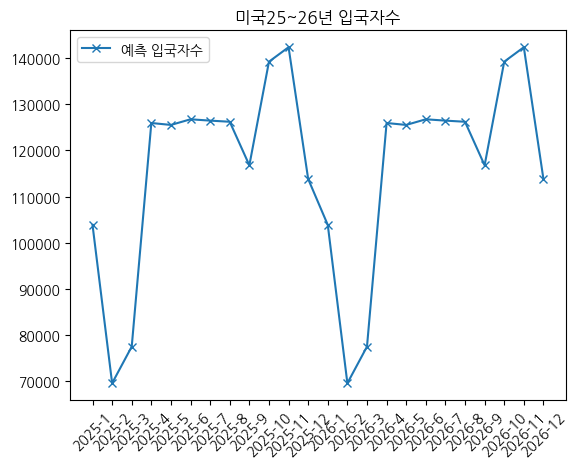

In [27]:
#과거, 미래 입국자를 그래프로 확인

import matplotlib.pyplot as plt

select_country = '미국'
#선택한 나라 데이터만 추출
select_df = df[df['국적지역']==select_country]

#입국자수 그래프
plt.figure(figsize=(15, 5))
plt.title(select_country + '18~24년 (20~22년 제외) 입국자수')
plt.plot(select_df['년'].astype(str) + '-' + select_df['월'].astype(str), select_df['입국자수'], marker='o', label='실제 입국자수')
plt.xticks(rotation=45)
plt.show()
#선택한 나라 예측입국자수 그래프
plt.title(select_country + '25~26년 입국자수')
plt.plot(future_df[future_df['국적지역']==select_country]['년'].astype(str) + '-' + future_df[future_df['국적지역']==select_country]['월'].astype(str), future_df[future_df['국적지역']==select_country]['예측 입국자수'], marker='x', label='예측 입국자수')

plt.xticks(rotation=45)
plt.legend()
plt.show()
